In [1]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
sys.path.append('/home/hiroki/research/dcase2021_task2/src/model_codes/MahalanobisAD')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
from scipy.stats import zscore
from umap import UMAP
from sklearn.mixture import GaussianMixture
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/UMAP_MVG_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '01_evaluation_notebook.ipynb')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
UMAP_MVG_MODEL_DIR = MODEL_DIR + '/UMAP_MVG'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(UMAP_MVG_MODEL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_res_sr32k_hyperalignment/config.yaml'

# load data

In [7]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [8]:
data_types = ['train', 'valid_source', 'valid_target']

In [9]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

def get_section_types(wav_names):
    section_types = []
    for wav_name in wav_names:
        if 'section_00' in wav_name:
            section_types.append(0)
        elif 'section_01' in wav_name:
            section_types.append(1)
        else:
            section_types.append(2)
    
    return section_types

section_types = get_section_types(wav_names)

# evaluation

## calc UMAPMVG

In [10]:
def train_UMAP_MVG(machine_type, n_components):
    UMAP_MVG = {}
    # load data
    ext_data = load_ext_data(machine_type)
    feats = ext_data['train']['features']
    # umap
    mapper = UMAP(n_components=n_components, random_state=42, n_neighbors=15)
    embedding = mapper.fit_transform(feats)
    # mvg
    mean = embedding.mean(axis=0)
    cov_estimator = LedoitWolf()
    cov_estimator.fit(embedding)
    cov = cov_estimator.covariance_
    # add
    UMAP_MVG['mean'] = mean
    UMAP_MVG['cov'] = cov
    UMAP_MVG['mapper'] = mapper
    return UMAP_MVG

In [11]:
def inference_UMAP_MVG(samples, UMAP_MVG):
    # UMAP decomposition
    samples = UMAP_MVG['mapper'].transform(samples)
    # get MVG
    mean = UMAP_MVG['mean']
    cov_inv = np.linalg.inv(UMAP_MVG['cov'])
    # calc mahalanobis
    maha = [mahalanobis(sample, mean, cov_inv) for sample in samples]
    maha = np.array(maha)
    return maha

In [12]:
search_components = [16,32,64,128,256,512]

In [ ]:
%%time

for machine_type in machine_types:
    logger.info(machine_type)
    out_dir = UMAP_MVG_MODEL_DIR + f'/{machine_type}'
    os.makedirs(out_dir, exist_ok=True)
    for n_components in search_components:
        logger.info(f'n_components = {n_components}')
        UMAP_MVG = train_UMAP_MVG(machine_type, n_components)
        pd.to_pickle(UMAP_MVG, f'{out_dir}/{machine_type}_components={n_components}.pkl')
        # inference
        logger.info('inference')
        for phase in ['valid_source', 'valid_target']:
            # load valid
            ext_data = load_ext_data(machine_type)
            samples = ext_data[phase]['features']
            # inference
            maha = inference_UMAP_MVG(samples, UMAP_MVG)
            # calc AUC
            roc_auc = roc_auc_score(ext_data[phase]['labels'], maha)
            logger.info(f'{machine_type} {phase} {n_components} : {roc_auc}')

2021-03-30 22:40:52,029 - 01_evaluation_notebook.ipynb - INFO - fan
2021-03-30 22:40:52,030 - 01_evaluation_notebook.ipynb - INFO - n_components = 16
2021-03-30 22:41:10,820 - 01_evaluation_notebook.ipynb - INFO - inference
2021-03-30 22:41:20,721 - 01_evaluation_notebook.ipynb - INFO - fan valid_source 16 : 0.47577777777777774
2021-03-30 22:41:28,542 - 01_evaluation_notebook.ipynb - INFO - fan valid_target 16 : 0.49776666666666664
2021-03-30 22:41:28,542 - 01_evaluation_notebook.ipynb - INFO - n_components = 32
2021-03-30 22:41:43,915 - 01_evaluation_notebook.ipynb - INFO - inference
2021-03-30 22:41:55,213 - 01_evaluation_notebook.ipynb - INFO - fan valid_source 32 : 0.5133555555555556
2021-03-30 22:42:06,418 - 01_evaluation_notebook.ipynb - INFO - fan valid_target 32 : 0.5017222222222222
2021-03-30 22:42:06,419 - 01_evaluation_notebook.ipynb - INFO - n_components = 64
2021-03-30 22:42:23,326 - 01_evaluation_notebook.ipynb - INFO - inference


In [12]:
MVG[machine_type]['cov'].shape

(3072, 3072)

## estimate

2021-03-19 22:11:34,426 - 00_train.py - INFO - fan valid_source AUC : 0.5406555555555554
2021-03-19 22:11:34,428 - 00_train.py - INFO - fan valid_target AUC : 0.5844


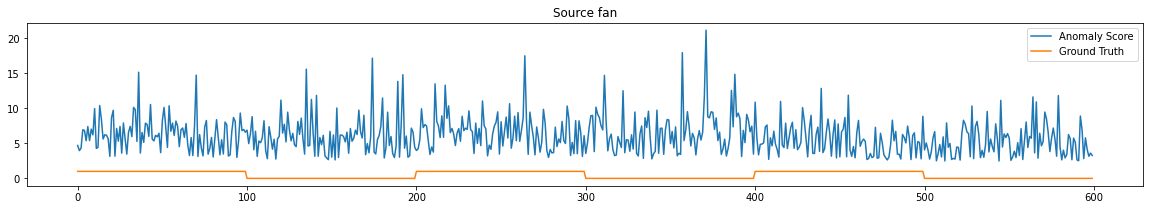

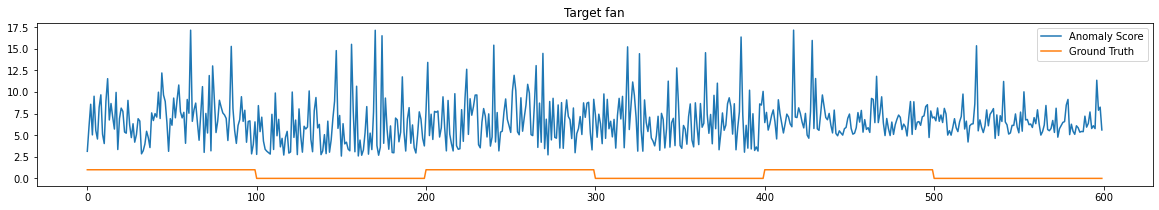

2021-03-19 22:11:37,942 - 00_train.py - INFO - gearbox valid_source AUC : 0.5983460533338878
2021-03-19 22:11:37,945 - 00_train.py - INFO - gearbox valid_target AUC : 0.6594525350593312


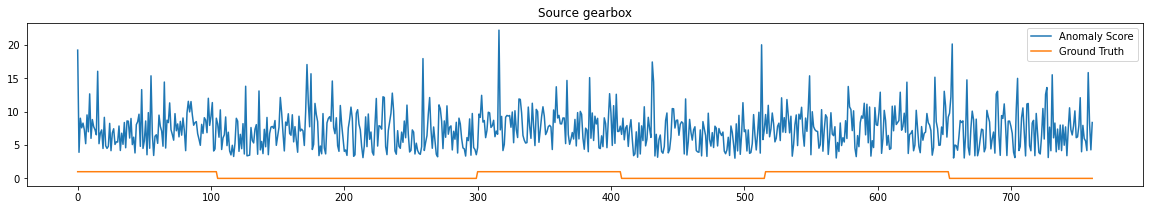

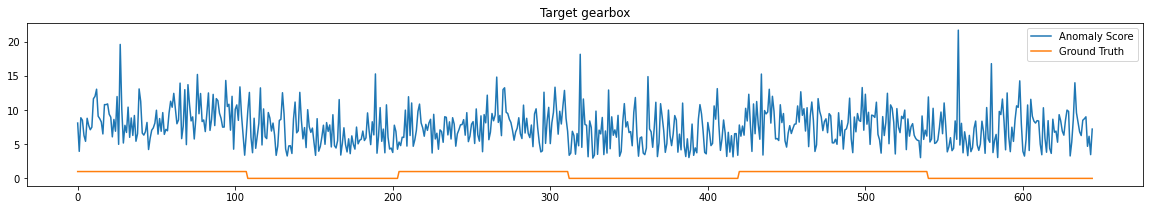

2021-03-19 22:11:41,272 - 00_train.py - INFO - pump valid_source AUC : 0.5820555555555555
2021-03-19 22:11:41,274 - 00_train.py - INFO - pump valid_target AUC : 0.5327666666666666


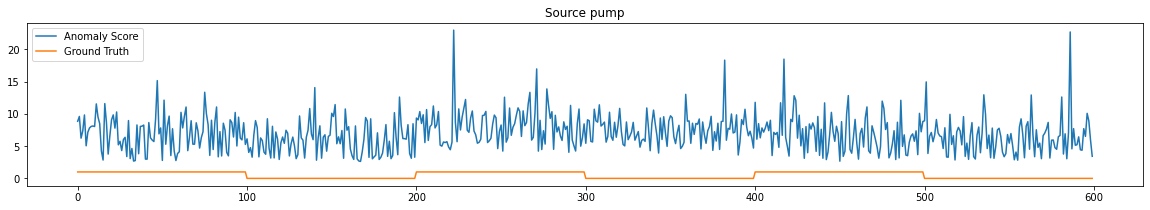

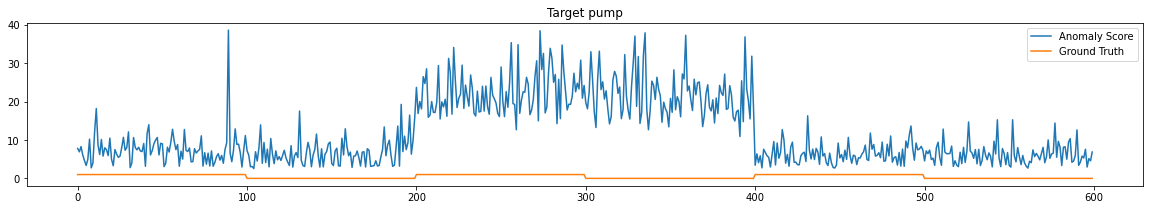

2021-03-19 22:11:44,855 - 00_train.py - INFO - slider valid_source AUC : 0.6277718436231575
2021-03-19 22:11:44,857 - 00_train.py - INFO - slider valid_target AUC : 0.6165783664459161


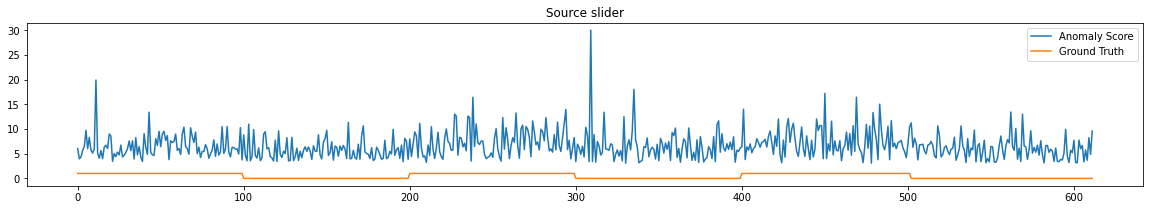

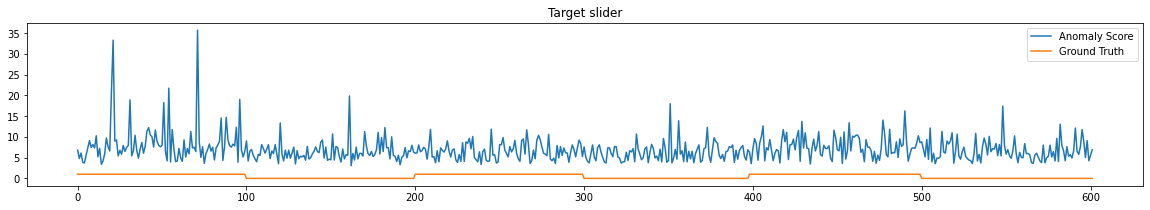

2021-03-19 22:11:48,126 - 00_train.py - INFO - ToyCar valid_source AUC : 0.6005555555555555
2021-03-19 22:11:48,128 - 00_train.py - INFO - ToyCar valid_target AUC : 0.5339333333333334


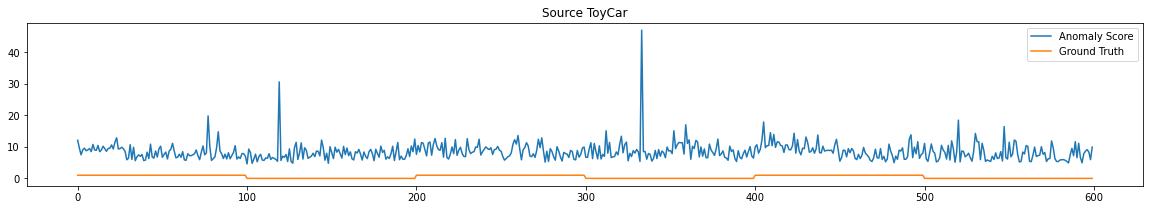

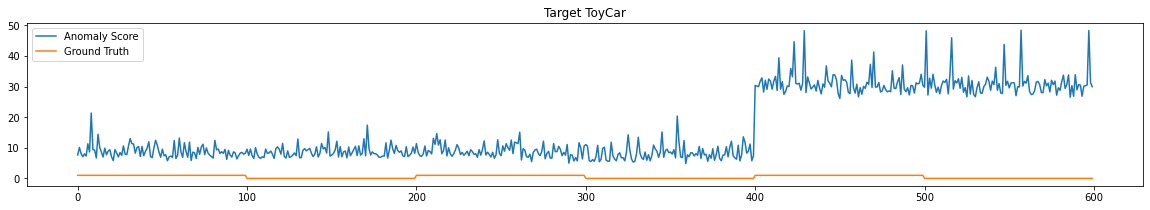

2021-03-19 22:11:51,503 - 00_train.py - INFO - ToyTrain valid_source AUC : 0.5067555555555556
2021-03-19 22:11:51,505 - 00_train.py - INFO - ToyTrain valid_target AUC : 0.49798888888888887


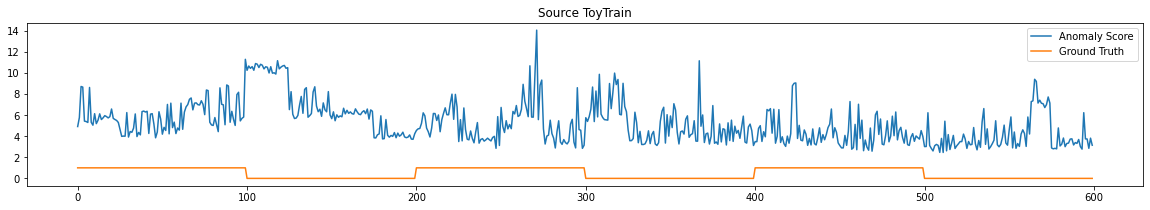

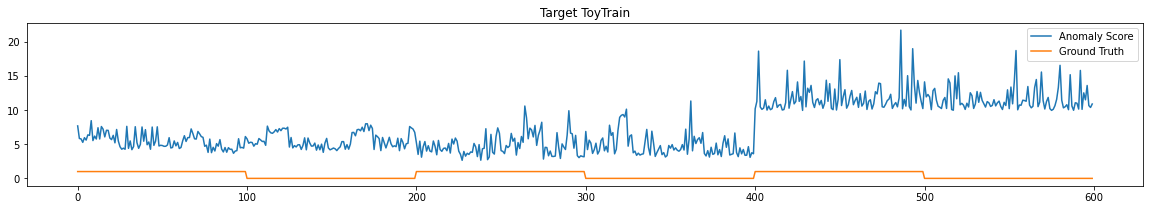

2021-03-19 22:11:54,714 - 00_train.py - INFO - valve valid_source AUC : 0.5298333333333334
2021-03-19 22:11:54,716 - 00_train.py - INFO - valve valid_target AUC : 0.5477777777777778


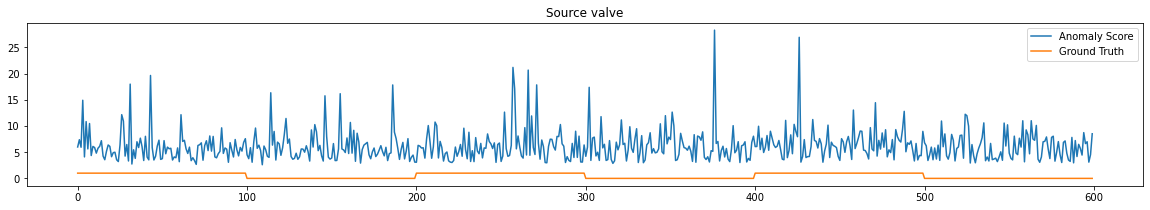

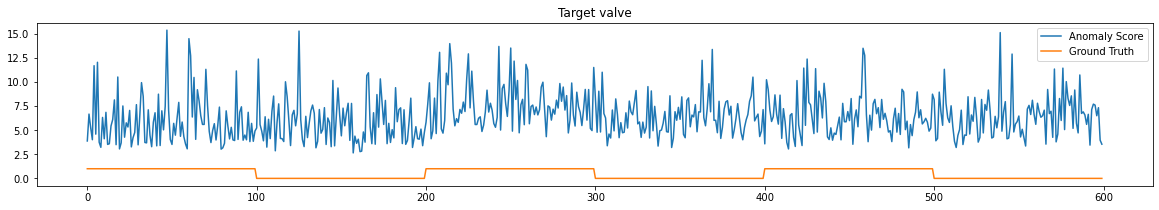

In [13]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

## calc GMM

In [11]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [12]:
ext_data = load_ext_data(machine_types[6])
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(ext_data['train']['features'])

GaussianMixture(n_components=3, random_state=42)

In [16]:
gmm.bic(ext_data['train']['features'])

3319258.8933906704

In [22]:
pred = gmm.predict(ext_data['train']['features'])

(array([ 790.,    0.,    0.,    0.,    0.,  378.,    0.,    0.,    0.,
        1841.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

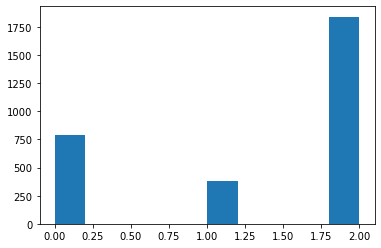

In [27]:
plt.hist(pred)

In [ ]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_

In [75]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_


# calc mahalanobis (Anomaly Score)
valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]

In [ ]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = MVG[machine_type]['cov']
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')

In [71]:
gmm_section_types = gmm.predict(feats)

/home/hiroki/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

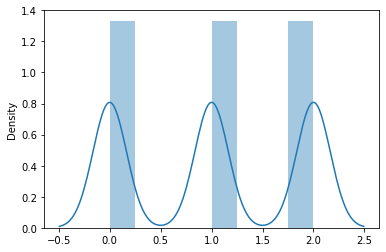

In [75]:
sns.distplot(section_types)

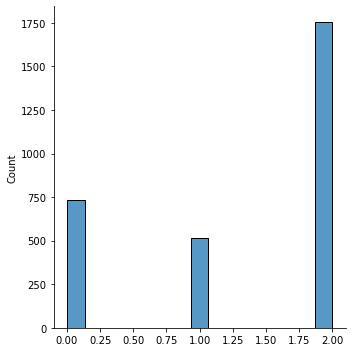

In [74]:
sns.displot(gmm_section_types)